In [14]:
import torch                                    # 导入torch
import torch.nn as nn                           # 导入torch.nn
import torch.nn.functional as F                 # 导入torch.nn.functional
import numpy as np 
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import warnings
import datetime
warnings.filterwarnings("ignore")

In [2]:
# 超参数
BATCH_SIZE = 32                                 # 样本数量
LR = 0.01                                       # 学习率
EPSILON = 0.9                                   # greedy policy
GAMMA = 0.9                                     # reward discount
TARGET_REPLACE_ITER = 100                       # 目标网络更新频率
MEMORY_CAPACITY = 10                            # 记忆库容量
N_ACTIONS = 64             
N_STATES = 64
actions = list(range(N_ACTIONS))
states = []

In [3]:
def get_dataset():
    # 读取数据并填补缺失值
    df = pd.read_excel('pred.xlsx')

    df[df==-99].count()
    df[df==-99] = np.nan

    numerical_feature = ['acAge', 'leGLU', 'leHCY', 'leHDLC', 'leLDLC', 'leTCHO', 'leTG', 'peBMI', 'peHeight', 'peWaistline', 'peWeight']
    categorical_feature = [ 'aName', 'acYear','aSex',  'acMarriage', 'dfAF', 'dfGlycuresis', 'dfHypertension', 'dfLDL', 'dfOverweight', 'dfSmoking', 'dfSportsLack', 'dfStrokeFamily', 'fhCHD', 'fhDM', 'lsDrink', 'lsDiet']
    dummy_feature = ['acEdu', 'acJob', 'acPayStyle']

    df[dummy_feature].mode().loc[0]
    df[categorical_feature].mode().loc[0]
    df[numerical_feature].mean()

    df = df.fillna(df[numerical_feature].mean()).fillna(df[categorical_feature].mode().loc[0]).fillna(df[dummy_feature].mode().loc[0])
    
    num_dic = {name: 'float64' for name in numerical_feature}
    cat_dic = {name: 'category' for name in categorical_feature}
    dum_dic = {name: 'category' for name in dummy_feature}
    df = df.astype(num_dic).astype(cat_dic).astype(dum_dic)
    # 去除无关的特征
    df = df.drop(['aName','acYear', 'nuNum', 'thick', 'unstable', 'UPJ'], axis=1)
    
    # 针对各个特征作处理
    # 年龄 min 39 max 94
    data_age = df['acAge'].values
    bins_age = [38, 50, 60, 70, 80, 90,100]
    label_age = ['age_4', 'age_5', 'age_6', 'age_7','age_8','age_9']
    age = pd.cut(data_age, bins_age, labels=label_age)
    col_age = pd.get_dummies(age)
    df = df.drop(['acAge'], axis=1).join(col_age)

    #空腹血糖 正常值 3.89～6.1mmol/l  min 2.1  max 21.4
    data_glu = df['leGLU'].values
    bins_glu = [2.0,3.89,6.1,21.5]
    label_glu = ['glu_low','glu_normal','glu_high']
    glu = pd.cut(data_glu, bins_glu, labels=label_glu)
    col_glu = pd.get_dummies(glu)
    df = df.drop(['leGLU'], axis=1).join(col_glu)

    # 低密度脂蛋白胆固醇 中老年人约3.37mmol,大于4.14mmol/L为明显增高 min 0.15 max 10.6
    data_ldlc = df['leLDLC'].values
    bins_ldlc = [0.14,2.7,4.13,10.7]
    label_ldlc = ['ldlc_low','ldlc_normal','ldlc_high']
    ldlc = pd.cut(data_ldlc, bins_ldlc, labels=label_ldlc)
    col_ldlc = pd.get_dummies(ldlc)
    df = df.drop(['leLDLC'], axis=1).join(col_ldlc)

    # 总胆固醇 成人总胆固醇正常值3.6-6.5mmol/L min 0.6  max 93.0
    data_tcho = df['leTCHO'].values
    bins_tcho = [0.5,3.5,6.5,94]
    label_tcho = ['tcho_low','tcho_normal','tcho_high']
    tcho = pd.cut(data_tcho, bins_tcho, labels=label_tcho)
    col_tcho = pd.get_dummies(tcho)
    df = df.drop(['leTCHO'], axis=1).join(col_tcho)

    # 同型半胱氨酸 15μmol/L以下算正常范围，如果高于15μmol/L以上，那么是算高同型半胱氨酸血症。
    data_hcy = df['leHCY'].values
    bins_hcy = [0,15,125]
    label_hcy = ['hcy_normal','hcy_high']
    hcy = pd.cut(data_hcy, bins_hcy, labels=label_hcy)
    col_hcy = pd.get_dummies(hcy)
    df = df.drop(['leHCY'], axis=1).join(col_hcy)

    # 高密度脂蛋白胆固醇 男性:1.16-1.42mmol/L、女性:1.29-1.55mmol/L
    data_hdlc = df['leHDLC'].values
    bins_hdlc = [0,1.16,1.55,11]
    label_hdlc = ['hdlc_low','hdlc_normal','hdlc_high']
    hdlc = pd.cut(data_hdlc, bins_hdlc, labels=label_hdlc)
    col_hdlc = pd.get_dummies(hdlc)
    df = df.drop(['leHDLC'], axis=1).join(col_hdlc)

    # 甘油三脂 <1.70mmol/L为正常值
    data_tg = df['leTG'].values
    bins_tg = [0,1.7,18]
    label_tg = ['tg_normal','tg_high']
    tg = pd.cut(data_tg, bins_tg, labels=label_tg)
    col_tg = pd.get_dummies(tg)
    df = df.drop(['leTG'], axis=1).join(col_tg)

    # 身体质量指数 (BMI) 偏瘦<= 18.4 正常18.5 ~ 23.9 过重24.0 ~ 27.9 肥胖	>= 28.0
    # min 0.2 ,max 54.17
    data_bmi = df['peBMI'].values
    bins_bmi = [0,18.4,23.9,27.9,54.2]
    label_bmi = ['bmi_low','bmi_normal','bmi_fat','bmi_over']
    bmi = pd.cut(data_bmi, bins_bmi, labels=label_bmi)
    col_bmi = pd.get_dummies(bmi)
    df = df.drop(['peBMI'], axis=1).join(col_bmi)

    # 身高 (height) 
    # min 118 ,max 188
    data_height = df['peHeight'].values
    bins_height = [0,120,150,160,170,180,2000]
    label_height = ['height_120','height_150','height_160','height_170','height_180','height_190']
    height = pd.cut(data_height, bins_height, labels=label_height)
    col_height = pd.get_dummies(height)
    df = df.drop(['peHeight'], axis=1).join(col_height)

    # 腰围 (Waistline) 
    # min50 max 172
    data_waistline = df['peWaistline'].values
    bins_waistline = [0,50,60,70,80,90,100,180]
    label_waistline = ['waistline_50','waistline_60','waistline_70','waistline_80','waistline_90','waistline_100','waistline_180']
    waistline = pd.cut(data_waistline, bins_waistline, labels=label_waistline)
    col_waistline = pd.get_dummies(waistline)
    df = df.drop(['peWaistline'], axis=1).join(col_waistline)

    # 体重 (Weight) 
    # min max
    data_weight = df['peWeight'].values
    bins_weight = [0,35,45,55,65,75,85,95,110]
    label_weight = ['weight_35','weight_45','weight_55','weight_65','weight_75','weight_85','weight_95','weight_110']
    weight = pd.cut(data_weight, bins_weight, labels=label_weight)
    col_weight = pd.get_dummies(weight)
    df = df.drop(['peWeight'], axis=1).join(col_weight)
    X = df.drop('nuResult', axis=1)
    Y = df['nuResult']
#     X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    return X, Y

In [4]:
def evaluate(a, s, step_num = 64):
    s = s.numpy()
    s_ = np.copy(s)
    s_[a] = 1
    if np.sum(s_)>=step_num:
        done = True
    else:
        done = False
    s_ = torch.tensor(s_)
    return s_, done

In [5]:
def step(a, s, X, y, step_num = 64):
    s = s.numpy()
    model = LogisticRegression(solver="sag")
#     colomn = list(X)
#     print('colomn:')
#     print(colomn)
    s_col = np.where(s>0)
    s_col = s_col[0].tolist()
    X_before = X.iloc[:,s_col]
    if len(s_col) == 0:
        acc_before = 0.685                 # 给定固定值
#         if len(result) == 0:
#             acc_before = 0
#         else:
#             acc_before = result[-1]/100  # 以上个回合结束的值作为这个回合的初始值
    else:        
#         print('X_before')
#         print(X_before)
        acc_before = cross_val_score(model, X_before, y, cv=5).mean()
#         acc_before = accuracy_score(y, y_before)
    
    X_after = X_before.join(X.iloc[:,a])
#     print('X_after')
#     print(X_after)
    acc_after = cross_val_score(model, X_after, y, cv=5).mean()
#     acc_after = accuracy_score(y, y_after)
    
    reward = (acc_after - acc_before)*100
    
    print(a)
    print(s)
    s_ = np.copy(s)
    s_[a] = 1
    print(s_)
    if np.sum(s_)>=step_num:
        done = True
    else:
        done = False
    if (s_ == s).all():
        print('s==s___，action={}'.format(a))
    else:
        print('state:')
        print(s)
        print('action:')
        print(a)
        print('reward')
        print(reward)
        print('s___')
        print(s_)
    s_ = torch.tensor(s_)
    return s_, reward, done
    

In [6]:
# 定义Net类
class Net(nn.Module):
    def __init__(self):                                                         # 定义Net的一系列属性
        # nn.Module的子类函数必须在构造函数中执行父类的构造函数
        super(Net, self).__init__()                                             # 等价与nn.Module.__init__()

        self.fc1 = nn.Linear(N_STATES, 256)                                      # 设置第一个全连接层(输入层到隐藏层): 状态数个神经元到50个神经元
        self.fc1.weight.data.normal_(0, 0.1)                                    # 权重初始化 (均值为0，方差为0.1的正态分布)
        self.fc2 = nn.Linear(256, 256)                                      # 设置第一个全连接层(输入层到隐藏层): 状态数个神经元到50个神经元
        self.fc2.weight.data.normal_(0, 0.1)
        self.out = nn.Linear(256, N_ACTIONS)                                     # 设置第二个全连接层(隐藏层到输出层): 50个神经元到动作数个神经元
        self.out.weight.data.normal_(0, 0.1) 

    def forward(self, x):                                                       # 定义forward函数 (x为状态)
#         valid_action_mask = x.type(torch.BoolTensor)
        x = F.relu(self.fc1(x))                                                 # 连接输入层到隐藏层，且使用激励函数ReLU来处理经过隐藏层后的值
        x = F.relu(self.fc2(x))  
        actions_value = self.out(x)                                             # 连接隐藏层到输出层，获得最终的输出值 (即动作值)
#         actions_value = torch.where(~valid_action_mask, actions_value, torch.tensor(-1e+8))
        return actions_value

In [7]:
# def get_action(self, x, action=None, invalid_action_masks=None):
#         logits = self.forward(x)
#         split_logits = torch.split(logits, env.action_space.nvec.tolist(), dim=1)
        
#         if invalid_action_masks is not None:
#             split_invalid_action_masks = torch.split(invalid_action_masks, env.action_space.nvec.tolist(), dim=1)
#             multi_categoricals = [CategoricalMasked(logits=logits, masks=iam) for (logits, iam) in zip(split_logits, split_invalid_action_masks)]
#         else:
#             multi_categoricals = [Categorical(logits=logits) for logits in split_logits]
        
#         if action is None:
#             action = torch.stack([categorical.sample() for categorical in multi_categoricals])
#         logprob = torch.stack([categorical.log_prob(a) for a, categorical in zip(action, multi_categoricals)])
#         return action, logprob, [], multi_categoricals

In [7]:
# 定义Invalid Action空间
# class CategoricalMasked(Categorical):
#     def __init__(self, probs=None, logits=None, validate_args=None, masks=[]):
#         self.masks = masks
#         if len(self.masks) == 0:
#             super(CategoricalMasked, self).__init__(probs, logits, validate_args)
#         else:
#             self.masks = masks.type(torch.BoolTensor).to(device)
#             logits = torch.where(self.masks, logits, torch.tensor(-1e+8).to(device))
#             super(CategoricalMasked, self).__init__(probs, logits, validate_args)
    
#     def entropy(self):
#         if len(self.masks) == 0:
#             return super(CategoricalMasked, self).entropy()
#         p_log_p = self.logits * self.probs
#         p_log_p = torch.where(self.masks, p_log_p, torch.tensor(0.).to(device))
#         return -p_log_p.sum(-1)


# 定义DQN类 (定义两个网络)
class DQN(object):
    def __init__(self):                                                         # 定义DQN的一系列属性
        self.eval_net, self.target_net = Net(), Net()                           # 利用Net创建两个神经网络: 评估网络和目标网络
        self.learn_step_counter = 0                                             # for target updating
        self.memory_counter = 0                                                 # for storing memory
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))             # 初始化记忆库，一行代表一个transition
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=LR)    # 使用Adam优化器 (输入为评估网络的参数和学习率)
        self.loss_func = nn.MSELoss()                                           # 使用均方损失函数 (loss(xi, yi)=(xi-yi)^2)

    def choose_action(self, x):                                                 # 定义动作选择函数 (x为状态)
#         valid_action_space = = list(set(actions).difference(set(states)))
#         valid_mask = np.ones(64,dtype=torch.BoolTensor)
#         valid_mask[i for i in states] = False
        
        if np.random.uniform() < EPSILON:                                       # 生成一个在[0, 1)内的随机数，如果小于EPSILON，选择最优动作
            action = self.predict(x)
        else:                                                                   # 随机选择动作
#             print('choose randomly')
            valid_action_mask = x.type(torch.BoolTensor)
            action_space = np.array([i for i in range(N_ACTIONS)])
            valid_action_mask = valid_action_mask.numpy()
            valid_action_space = np.where(~valid_action_mask,action_space,-1)
#             valid_actions = []
            action = []
#             print('valid_action_space')
#             print(valid_action_space)
#             for valid in valid_action_space:
#                 select = valid[(valid> -1)]
#                 print('select:')
#                 print(select)
#                 a = np.random.choice(select)
#                 action.append(a)
#             action = np.array(action)
            selection = valid_action_space[(valid_action_space)>-1]
            action = np.random.choice(selection)            
#             print('action')
#             print(action)
#                 valid_actions.append(select)
#             valid_actions = torch.tensor([item.detach().numpy() for item in valid_actions])
#             print('valid_actions')
#             print(valid_actions)           
#             action = np.random.choice(valid_actions)                             # 这里action随机等于0或1 (N_ACTIONS = 2)
        return action                                                           # 返回选择的动作 (0或1)

    def predict(self, x):        
        valid_action_mask = x.type(torch.BoolTensor)
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
#         print('choose from net')
        actions_value = self.eval_net.forward(x)                            # 通过对评估网络输入状态x，前向传播获得动作值
#         print('actions_value')
#         print(actions_value)
        actions_value = torch.where(~valid_action_mask, actions_value, torch.tensor(-1e+8))
        action = torch.max(actions_value, 1)[1].data.numpy()                # 输出每一行最大值的索引，并转化为numpy ndarray形式
        action = action[0]                                                  # 输出action的第一个数
        return action

    def store_transition(self, s, a, r, s_):                                    # 定义记忆存储函数 (这里输入为一个transition)
        transition = np.hstack((s, [a, r], s_))                                 # 在水平方向上拼接数组
        # 如果记忆库满了，便覆盖旧的数据
        index = self.memory_counter % MEMORY_CAPACITY                           # 获取transition要置入的行数
        self.memory[index, :] = transition                                      # 置入transition
        self.memory_counter += 1                                                # memory_counter自加1

    def learn(self):                                                            # 定义学习函数(记忆库已满后便开始学习)
        # 目标网络参数更新
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:                  # 一开始触发，然后每100步触发
            print('target net update...')
            self.target_net.load_state_dict(self.eval_net.state_dict())         # 将评估网络的参数赋给目标网络
        self.learn_step_counter += 1                                            # 学习步数自加1

        # 抽取记忆库中的批数据
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)            # 在[0, 2000)内随机抽取32个数，可能会重复
        b_memory = self.memory[sample_index, :]                                 # 抽取32个索引对应的32个transition，存入b_memory
        b_s = torch.FloatTensor(b_memory[:, :N_STATES])
        # 将32个s抽出，转为32-bit floating point形式，并存储到b_s中，b_s为32行64列
        b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].astype(int))
        # 将32个a抽出，转为64-bit integer (signed)形式，并存储到b_a中 (之所以为LongTensor类型，是为了方便后面torch.gather的使用)，b_a为32行1列
        b_r = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        # 将32个r抽出，转为32-bit floating point形式，并存储到b_s中，b_r为32行1列
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])
        # 将32个s_抽出，转为32-bit floating point形式，并存储到b_s中，b_s_为32行64列

        # 获取32个transition的评估值和目标值，并利用损失函数和优化器进行评估网络参数更新
        q_eval = self.eval_net(b_s).gather(1, b_a)
        # eval_net(b_s)通过评估网络输出32行每个b_s对应的一系列动作值，然后.gather(1, b_a)代表对每行对应索引b_a的Q值提取进行聚合
        q_next = self.target_net(b_s_).detach()
        # q_next不进行反向传递误差，所以detach；q_next表示通过目标网络输出32行每个b_s_对应的一系列动作值
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)
        # q_next.max(1)[0]表示只返回每一行的最大值，不返回索引(长度为32的一维张量)；.view()表示把前面所得到的一维张量变成(BATCH_SIZE, 1)的形状；最终通过公式得到目标值
        loss = self.loss_func(q_eval, q_target)
        print('========================')
        print('loss:{}'.format(loss))
        print('========================')
        # 输入32个评估值和32个目标值，使用均方损失函数
        self.optimizer.zero_grad()                                      # 清空上一步的残余更新参数值
        loss.backward()                                                 # 误差反向传播, 计算参数更新值
        self.optimizer.step()                                           # 更新评估网络的所有参数
        

    def save_replay_buffer(self,filename):
        np.save(filename,self.memory)
        
    def load_replay_buffer(self, replay_buffer):
        self.memory = np.load('replay_buffer.npy')
      
    def update_memory_pool(self,X,y):
        print('previous memory reward')
        print(self.memory[:,N_STATES+1])
        self.memory = self.memory[self.memory[:,N_STATES+1].argsort()]
#         update_sample = 1
        update_memory = self.memory[0]
        update_s = torch.FloatTensor(update_memory[:N_STATES])

        while True:
            update_a = self.choose_action(update_s)
            update_s_, update_r, done = step(update_a,update_s,X,y)
            self.store_transition(update_s,update_a,update_r,update_s_)
            update_s = update_s_
            if done:
                break
        print('==============')
        print(self.memory[:,N_STATES+1])
        
        

In [141]:
dqn = DQN()                                                             # 令dqn=DQN类
result = []

# 采样放入经验池
for i in range(100):                                                    # 400个episode循环
    print('<<<<<<<<<Episode: %s' % i)
    s = torch.zeros(64)
    X, y = get_dataset()
    episode_reward_sum = 0                                              # 初始化该循环对应的episode的总奖励

    while True:                                                         # 开始一个episode (每一个循环代表一步)                                                # 显示实验动画
        a = dqn.choose_action(s)                                        # 输入该步对应的状态s，选择动作
        s_, r, done = step(a,s,X,y)                                 # 执行动作，获得反馈

        # 修改奖励 (不修改也可以，修改奖励只是为了更快地得到训练好的摆杆)
#         x, x_dot, theta, theta_dot = s_
#         r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
#         r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
#         new_r = r1 + r2

        dqn.store_transition(s, a, r, s_)                     # 存储样本
        episode_reward_sum += r                               # 逐步加上一个episode内每个step的reward

        s = s_                                                # 更新状态
            
        if done:       # 如果done为True
            # round()方法返回episode_reward_sum的小数点四舍五入到2个数字
            print('episode%s---reward_sum: %s' % (i, round(episode_reward_sum, 2)))
            result.append(episode_reward_sum)
            break                                             # 该episode结束
            
        if dqn.memory_counter > MEMORY_CAPACITY:
            break
            
    if dqn.memory_counter > MEMORY_CAPACITY:
        break
 
dqn.save_replay_buffer('replay_buffer2.npy')
# dqn.update_memory_pool(X,y)

# 开始训练DQN
# print('start train...')
# epoch = 0
# max_epoch = 1000
# while epoch<max_epoch:
#     for i in range(50):
#         dqn.learn()
#         epoch += 1
#     print("start test")
#     total_result = []
#     for n in range(1,65):
#         print('choose {} feature...'.format(n))
# #         test_reward_sum = 0
#         test_s = torch.zeros(64)
#         while True:                        
#             test_a = dqn.predict(test_s)
# #             test_s_, test_r, test_done = step(test_a,test_s,X,y,n)
#             test_s_, test_done = evaluate(test_a, test_s, n)
# #             test_reward_sum += test_r
#             test_s = test_s_
#             if test_done:
# #                 total_result.append(test_reward_sum)                
#                 break
#         model = LogisticRegression(solver="sag")
#         s_test_col = np.where(test_s.numpy()>0)
#         s_test_col = s_test_col[0].tolist()
#         print('{}:X_test feature:'.format(n))
#         print(s_test_col)
#         X_test = X.iloc[:,s_test_col]
#         acc_test = cross_val_score(model, X_test, y, cv=5).mean()
#         total_result.append(acc_test)
# #                 print('{} epoch:result:{}'.format(i,acc_test))
#     print('epoch {}:'.format(epoch))
#     print(total_result)
    
#     if i % 10 == 0:
#         print("start test")
#         test_s = torch.zeros(64)
#         test_a = dqn.predict(test_s)
#         test_s_, test_r, test_done = step(test_a,test_s,X,y)
#         test_reward_sum = test_r
#         while not test_done:
#             test_s = test_s_
#             if torch.sum(test_s)==32:
#                 model = LogisticRegression(solver="sag")
#                 s_col = np.where(test_s.numpy()>0)
#                 s_col = s_col[0].tolist()
#                 print('{}:X_test feature:'.format(i))
#                 print(s_col)
#                 X_test = X.iloc[:,s_col]
#                 acc_test = cross_val_score(model, X_test, y, cv=5).mean()
#                 print('result:{}'.format(acc_test))
#             test_a = dqn.predict(test_s)
#             test_s_, test_r, test_done = step(test_a,test_s,X,y)
#             test_reward_sum += test_r
# print(result)




In [11]:
dqn2 = DQN()
dqn2.load_replay_buffer('replay_buffer2.npy')
dqn2.memory


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [3]:
dqn = DQN()                                                             # 令dqn=DQN类
result = []

# 采样放入经验池
for i in range(100):                                                    # 400个episode循环
    print('<<<<<<<<<Episode: %s' % i)
    s = torch.zeros(64)
    X, y = get_dataset()
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022,test_size=0.25, shuffle=True)
    episode_reward_sum = 0                                              # 初始化该循环对应的episode的总奖励

    while True:                                                         # 开始一个episode (每一个循环代表一步)                                                # 显示实验动画
        a = dqn.choose_action(s)                                        # 输入该步对应的状态s，选择动作
        s_, r, done = step(a,s,X,y)                                 # 执行动作，获得反馈

        # 修改奖励 (不修改也可以，修改奖励只是为了更快地得到训练好的摆杆)
#         x, x_dot, theta, theta_dot = s_
#         r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
#         r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
#         new_r = r1 + r2

        dqn.store_transition(s, a, r, s_)                     # 存储样本
        episode_reward_sum += r                               # 逐步加上一个episode内每个step的reward

        s = s_                                                # 更新状态
            
        if done:       # 如果done为True
            # round()方法返回episode_reward_sum的小数点四舍五入到2个数字
            print('episode%s---reward_sum: %s' % (i, round(episode_reward_sum, 2)))
            result.append(episode_reward_sum)
            break                                             # 该episode结束
            
    if dqn.memory_counter > MEMORY_CAPACITY:
        break
        

# 开始训练DQN
print('start train...')
epoch = 0
max_epoch = 600
best_reward = 0
while epoch<max_epoch:
    for i in range(10):
        dqn.learn()
        epoch += 1
    print("start test")
    total_result = []
    for n in range(1,65):
        print('choose {} feature...'.format(n))
#         test_reward_sum = 0
        test_s = torch.zeros(64)
        while True:                        
            test_a = dqn.predict(test_s)
#             test_s_, test_r, test_done = step(test_a,test_s,X,y,n)
            test_s_, test_done = evaluate(test_a, test_s, n)
#             test_reward_sum += test_r
            test_s = test_s_
            if test_done:
#                 total_result.append(test_reward_sum)                
                break
        model = LogisticRegression(solver="sag")
        s_test_col = np.where(test_s.numpy()>0)
        s_test_col = s_test_col[0].tolist()
        print('{}:X_test feature:'.format(n))
        print(s_test_col)
#         X_train_select = X_train.iloc[:,s_test_col]
#         X_test_select = X_test.iloc[:,s_test_col]
#         model.fit(X_train_select, y_train)
#         y_predict = model.predict(X_test_select)
#         acc_test = accuracy_score(y_test, y_predict)
        X_test_select = X.iloc[:,s_test_col]
        acc_test = cross_val_score(model, X_test_select, y, cv=5).mean()
        total_result.append(acc_test)
        print('result:{}'.format(acc_test))
    print('epoch {}:'.format(epoch))
    print(total_result)
    if np.sum(total_result)>best_reward:
        best_reward = np.sum(total_result)
        print('best reward is:{}'.format(best_reward))
        print('save model...')
#         torch.save(dqn.eval_net.state_dict(), '0721_{}_{}_{}_eval_base.pth'.format(MEMORY_CAPACITY,epoch,GAMMA))
#         torch.save(dqn.target_net.state_dict(), '0721_{}_{}_{}_target_base.pth'.format(MEMORY_CAPACITY,epoch,GAMMA))
    
#     if i % 10 == 0:
#         print(\"start test\")
#         test_s = torch.zeros(64)
#         test_a = dqn.predict(test_s)
#         test_s_, test_r, test_done = step(test_a,test_s,X,y)
#         test_reward_sum = test_r
#         while not test_done:
#             test_s = test_s_
#             if torch.sum(test_s)==32:
#                 model = LogisticRegression(solver=\"sag\")
#                 s_col = np.where(test_s.numpy()>0)
#                 s_col = s_col[0].tolist()
#                 print('{}:X_test feature:'.format(i))
#                 print(s_col)
#                 X_test = X.iloc[:,s_col]
#                 acc_test = cross_val_score(model, X_test, y, cv=5).mean()
#                 print('result:{}'.format(acc_test))
#             test_a = dqn.predict(test_s)
#             test_s_, test_r, test_done = step(test_a,test_s,X,y)
#             test_reward_sum += test_r
# print(result)



Button(description='Clear!', style=ButtonStyle())

Button(description='Click Me!', style=ButtonStyle())

Output()

In [23]:
X, Y = get_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

dqn_test = DQN()
eval_net, target_net = Net(), Net()
eval_net.load_state_dict(torch.load("single_10000_0.99_0.01_16_500_eval.pth"))
# target_net.load_state_dict(torch.load('total_10000_0.99_0.001_32_500_target.pth'))
dqn_test.eval_net = eval_net
dqn_test.target_net = target_net
total_result = []
for n in range(1,65):
    print('choose {} feature...'.format(n))
#         test_reward_sum = 0
    test_s = torch.zeros(64)
    while True:         
        with torch.no_grad():
            test_a = dqn_test.predict(test_s)
#             test_s_, test_r, test_done = step(test_a,test_s,X,y,n)
        test_s_, test_done = evaluate(test_a, test_s, n)
#             test_reward_sum += test_r
        test_s = test_s_
        if test_done:
#                 total_result.append(test_reward_sum)                
            break
    model = LogisticRegression(solver="sag")
    s_test_col = np.where(test_s.numpy()>0)
    s_test_col = s_test_col[0].tolist()
    print('{}:X_test feature:'.format(n))
    print(s_test_col)
    X_train_select = X_train.iloc[:,s_test_col]
    X_test_select = X_test.iloc[:,s_test_col]
    model.fit(X_train_select, y_train)
    y_pred = model.predict(X_test_select)
#     acc_test = accuracy_score(y_test, y_pred)
#     pre_test = precision_score(y_test, y_pred)
    rec_test = recall_score(y_test, y_pred)
#     acc_test = cross_val_score(model, X_test_select, y, cv=5).mean()
    total_result.append(rec_test)
    print('result:{}'.format(rec_test))
print(total_result)

choose 1 feature...
1:X_test feature:
[18]
result:1.0
choose 2 feature...
2:X_test feature:
[2, 18]
result:1.0
choose 3 feature...
3:X_test feature:
[2, 18, 19]
result:0.9525483304042179
choose 4 feature...
4:X_test feature:
[2, 5, 18, 19]
result:0.8453427065026362
choose 5 feature...
5:X_test feature:
[2, 5, 15, 18, 19]
result:0.804920913884007
choose 6 feature...
6:X_test feature:
[2, 5, 9, 15, 18, 19]
result:0.8409490333919156
choose 7 feature...
7:X_test feature:
[2, 5, 9, 15, 18, 19, 20]
result:0.8418277680140598
choose 8 feature...
8:X_test feature:
[2, 5, 9, 15, 17, 18, 19, 20]
result:0.8418277680140598
choose 9 feature...
9:X_test feature:
[2, 4, 5, 9, 15, 17, 18, 19, 20]
result:0.836555360281195
choose 10 feature...
10:X_test feature:
[2, 4, 5, 9, 15, 17, 18, 19, 20, 26]
result:0.8541300527240774
choose 11 feature...
11:X_test feature:
[2, 4, 5, 9, 13, 15, 17, 18, 19, 20, 26]
result:0.8523725834797891
choose 12 feature...
12:X_test feature:
[1, 2, 4, 5, 9, 13, 15, 17, 18, 19, 

result:0.8576449912126538
choose 52 feature...
52:X_test feature:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 33, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 61, 63]
result:0.8576449912126538
choose 53 feature...
53:X_test feature:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 61, 63]
result:0.8541300527240774
choose 54 feature...
54:X_test feature:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54, 55, 57, 58, 59, 61, 63]
result:0.8541300527240774
choose 55 feature...
55:X_test feature:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 31, 32, 33, 35, 36, 37, 

In [13]:
X.columns[[4,15,17,18,26]]

Index(['dfGlycuresis', 'acPayStyle', 'age_4', 'age_5', 'ldlc_low'], dtype='object')

In [158]:
base_test_result = {}
base_test_result['target_random'] = [0.6973039215686274,
 0.6973039215686274,
 0.6973039215686274,
 0.7083333333333334,
 0.7083333333333334,
 0.7083333333333334,
 0.7083333333333334,
 0.7113970588235294,
 0.7095588235294118,
 0.7150735294117647,
 0.727328431372549,
 0.7285539215686274,
 0.7230392156862745,
 0.7230392156862745,
 0.7248774509803921,
 0.7248774509803921,
 0.7254901960784313,
 0.7230392156862745,
 0.7377450980392157,
 0.7352941176470589,
 0.7291666666666666,
 0.7285539215686274,
 0.727328431372549,
 0.7285539215686274,
 0.7297794117647058,
 0.7371323529411765,
 0.7365196078431373,
 0.7365196078431373,
 0.7359068627450981,
 0.7352941176470589,
 0.758578431372549,
 0.758578431372549,
 0.758578431372549,
 0.758578431372549,
 0.7573529411764706,
 0.7573529411764706,
 0.7567401960784313,
 0.7573529411764706,
 0.7573529411764706,
 0.7567401960784313,
 0.7579656862745098,
 0.7610294117647058,
 0.7622549019607843,
 0.7628676470588235,
 0.7573529411764706,
 0.7579656862745098,
 0.7579656862745098,
 0.7579656862745098,
 0.7567401960784313,
 0.7598039215686274,
 0.7647058823529411,
 0.7647058823529411,
 0.7616421568627451,
 0.7671568627450981,
 0.7677696078431373,
 0.7689950980392157,
 0.7696078431372549,
 0.7683823529411765,
 0.7677696078431373,
 0.7677696078431373,
 0.7696078431372549,
 0.7696078431372549,
 0.7696078431372549,
 0.7702205882352942]
base_test_result['dqn_10000_16_0.9'] = [0.6973039215686274, 0.6973039215686274, 0.6985294117647058, 0.7236519607843137, 0.727328431372549, 0.7242647058823529, 0.7291666666666666, 0.7310049019607843, 0.7377450980392157, 0.7377450980392157, 0.7383578431372549, 0.7383578431372549, 0.7457107843137255, 0.7469362745098039, 0.7487745098039216, 0.7469362745098039, 0.7475490196078431, 0.7463235294117647, 0.7481617647058824, 0.7481617647058824, 0.7579656862745098, 0.758578431372549, 0.7598039215686274, 0.7604166666666666, 0.7598039215686274, 0.7616421568627451, 0.7628676470588235, 0.7604166666666666, 0.7610294117647058, 0.758578431372549, 0.7622549019607843, 0.7616421568627451, 0.7616421568627451, 0.7616421568627451, 0.7628676470588235, 0.7622549019607843, 0.7622549019607843, 0.7622549019607843, 0.7622549019607843, 0.7622549019607843, 0.7720588235294118, 0.7720588235294118, 0.7757352941176471, 0.7751225490196079, 0.7763480392156863, 0.7781862745098039, 0.7763480392156863, 0.7769607843137255, 0.7751225490196079, 0.7751225490196079, 0.7683823529411765, 0.7671568627450981, 0.7689950980392157, 0.7689950980392157, 0.7689950980392157, 0.7677696078431373, 0.7689950980392157, 0.7689950980392157, 0.7683823529411765, 0.7683823529411765, 0.7683823529411765, 0.7683823529411765, 0.7696078431372549, 0.7702205882352942]
base_test_result['dqn_10000_16_0.01'] = [0.6973039215686274, 0.6973039215686274, 0.6936274509803921, 0.7162990196078431, 0.6942401960784313, 0.7279411764705882, 0.7395833333333334, 0.7395833333333334, 0.7463235294117647, 0.7536764705882353, 0.7530637254901961, 0.7647058823529411, 0.7610294117647058, 0.7604166666666666, 0.7604166666666666, 0.7604166666666666, 0.7634803921568627, 0.7634803921568627, 0.7610294117647058, 0.7653186274509803, 0.7671568627450981, 0.7671568627450981, 0.7677696078431373, 0.7659313725490197, 0.7677696078431373, 0.7683823529411765, 0.7683823529411765, 0.7683823529411765, 0.7659313725490197, 0.772671568627451, 0.7720588235294118, 0.7702205882352942, 0.7708333333333334, 0.7702205882352942, 0.7732843137254902, 0.7732843137254902, 0.7738970588235294, 0.7689950980392157, 0.7696078431372549, 0.7751225490196079, 0.7738970588235294, 0.7732843137254902, 0.7732843137254902, 0.7732843137254902, 0.7751225490196079, 0.7763480392156863, 0.7757352941176471, 0.7757352941176471, 0.7745098039215687, 0.772671568627451, 0.7732843137254902, 0.7732843137254902, 0.7677696078431373, 0.7689950980392157, 0.7677696078431373, 0.7677696078431373, 0.7683823529411765, 0.7677696078431373, 0.7677696078431373, 0.7683823529411765, 0.7677696078431373, 0.7683823529411765, 0.7696078431372549, 0.7702205882352942]
base_test_result['dqn_10000_16']=[0.7083333333333334,
 0.7083333333333334,
 0.71875,
 0.727328431372549,
 0.7083333333333334,
 0.71875,
 0.7303921568627451,
 0.7610294117647058,
 0.7604166666666666,
 0.758578431372549,
 0.7573529411764706,
 0.7659313725490197,
 0.7622549019607843,
 0.7628676470588235,
 0.7634803921568627,
 0.7640931372549019,
 0.7634803921568627,
 0.7665441176470589,
 0.7634803921568627,
 0.7634803921568627,
 0.7622549019607843,
 0.7640931372549019,
 0.7647058823529411,
 0.7659313725490197,
 0.7659313725490197,
 0.7665441176470589,
 0.7665441176470589,
 0.7665441176470589,
 0.7665441176470589,
 0.7665441176470589,
 0.7714460784313726,
 0.7714460784313726,
 0.7702205882352942,
 0.7696078431372549,
 0.7702205882352942,
 0.7702205882352942,
 0.7696078431372549,
 0.7683823529411765,
 0.7683823529411765,
 0.7683823529411765,
 0.7683823529411765,
 0.7683823529411765,
 0.7671568627450981,
 0.7677696078431373,
 0.7683823529411765,
 0.7683823529411765,
 0.7677696078431373,
 0.7677696078431373,
 0.7671568627450981,
 0.7671568627450981,
 0.7671568627450981,
 0.7665441176470589,
 0.7665441176470589,
 0.7665441176470589,
 0.7659313725490197,
 0.7647058823529411,
 0.7653186274509803,
 0.7665441176470589,
 0.7665441176470589,
 0.7689950980392157,
 0.7696078431372549,
 0.7702205882352942,
 0.7689950980392157,
 0.7702205882352942]


base_test_result['f_test'] = [0.6973039215686274, 0.6985294117647058, 0.7126225490196079, 0.7015931372549019, 0.7009803921568627, 0.7248774509803921, 0.7285539215686274, 0.7383578431372549, 0.7450980392156863, 0.7450980392156863, 0.7463235294117647, 0.7444852941176471, 0.7389705882352942, 0.7426470588235294, 0.7426470588235294, 0.7426470588235294, 0.7549019607843137, 0.7567401960784313, 0.7579656862745098, 0.7604166666666666, 0.7610294117647058, 0.7610294117647058, 0.7616421568627451, 0.7616421568627451, 0.7598039215686274, 0.7591911764705882, 0.7567401960784313, 0.7561274509803921, 0.7567401960784313, 0.7573529411764706, 0.7598039215686274, 0.7634803921568627, 0.7634803921568627, 0.7628676470588235, 0.7622549019607843, 0.7622549019607843, 0.7640931372549019, 0.7634803921568627, 0.7634803921568627, 0.7634803921568627, 0.7628676470588235, 0.7634803921568627, 0.7647058823529411, 0.7653186274509803, 0.7647058823529411, 0.7647058823529411, 0.7640931372549019, 0.7634803921568627, 0.7647058823529411, 0.7640931372549019, 0.7640931372549019, 0.7671568627450981, 0.7671568627450981, 0.7671568627450981, 0.7677696078431373, 0.7677696078431373, 0.7714460784313726, 0.7696078431372549, 0.7696078431372549, 0.7696078431372549, 0.7696078431372549, 0.7702205882352942, 0.7702205882352942, 0.7702205882352942]
base_test_result['mutual_info'] = [0.6973039215686274, 0.7175245098039216, 0.7126225490196079, 0.7113970588235294, 0.7028186274509803, 0.7052696078431373, 0.7408088235294118, 0.7297794117647058, 0.7365196078431373, 0.7463235294117647, 0.7463235294117647, 0.7432598039215687, 0.7450980392156863, 0.7469362745098039, 0.7408088235294118, 0.7389705882352942, 0.7426470588235294, 0.7598039215686274, 0.7450980392156863, 0.741421568627451, 0.7573529411764706, 0.7549019607843137, 0.7616421568627451, 0.7567401960784313, 0.7469362745098039, 0.7506127450980392, 0.7463235294117647, 0.7573529411764706, 0.7530637254901961, 0.7634803921568627, 0.7567401960784313, 0.7634803921568627, 0.7610294117647058, 0.7640931372549019, 0.7616421568627451, 0.7640931372549019, 0.7647058823529411, 0.7622549019607843, 0.7659313725490197, 0.7555147058823529, 0.7665441176470589, 0.7683823529411765, 0.7604166666666666, 0.7567401960784313, 0.7604166666666666, 0.7628676470588235, 0.7640931372549019, 0.7530637254901961, 0.7604166666666666, 0.7659313725490197, 0.7634803921568627, 0.7640931372549019, 0.7647058823529411, 0.7689950980392157, 0.7659313725490197, 0.7665441176470589, 0.7659313725490197, 0.7683823529411765, 0.7653186274509803, 0.7634803921568627, 0.7683823529411765, 0.7659313725490197, 0.7689950980392157, 0.7702205882352942]
base_test_result['chi2'] = [0.7083333333333334, 0.6973039215686274, 0.7218137254901961, 0.7377450980392157, 0.7359068627450981, 0.7506127450980392, 0.7426470588235294, 0.7420343137254902, 0.741421568627451, 0.7389705882352942, 0.7371323529411765, 0.7371323529411765, 0.7371323529411765, 0.7359068627450981, 0.7365196078431373, 0.7487745098039216, 0.7475490196078431, 0.7481617647058824, 0.7493872549019608, 0.75, 0.75, 0.7530637254901961, 0.7530637254901961, 0.7536764705882353, 0.7604166666666666, 0.7622549019607843, 0.7591911764705882, 0.7567401960784313, 0.7604166666666666, 0.758578431372549, 0.7591911764705882, 0.7561274509803921, 0.7561274509803921, 0.7622549019607843, 0.7622549019607843, 0.7628676470588235, 0.7616421568627451, 0.7610294117647058, 0.7616421568627451, 0.7616421568627451, 0.7604166666666666, 0.7604166666666666, 0.7604166666666666, 0.7610294117647058, 0.7604166666666666, 0.7604166666666666, 0.7604166666666666, 0.7604166666666666, 0.7591911764705882, 0.7598039215686274, 0.7634803921568627, 0.7634803921568627, 0.7659313725490197, 0.7671568627450981, 0.7683823529411765, 0.7677696078431373, 0.7714460784313726, 0.7696078431372549, 0.7696078431372549, 0.7696078431372549, 0.7696078431372549, 0.7696078431372549, 0.7702205882352942, 0.7702205882352942]

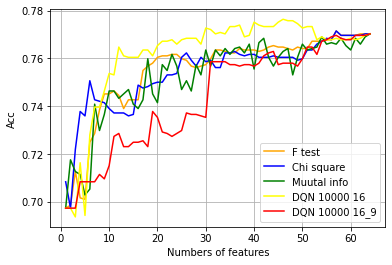

In [159]:
# 结果画图
import matplotlib.pyplot as plt

x = range(1,65)
# y = range(0.)

# plt.xlim(0,5)
# plt.ylim(0,7)

plt.plot(x, base_test_result['f_test'], color='orange', label='F test')
plt.plot(x, base_test_result['chi2'], color='blue', label='Chi square')
plt.plot(x, base_test_result['mutual_info'], color='green', label='Muutal info')

# plt.plot(x, base_test_result['dqn_500'], color='red', label='DQN 500')
# plt.plot(x, base_test_result['dqn_500_trainset_random'], color='yellow', label='DQN 500 trainset')
# plt.plot(x, base_test_result['dqn_6400_trainset_random'], color='purple', label='DQN 6400 trainset')
# plt.plot(x, base_test_result['dqn_1000_trainset_random'], color='red', label='DQN 1000 trainset')
# plt.plot(x, base_test_result['dqn_10000_16'], color='purple', label='DQN 10000 trainset')
plt.plot(x, base_test_result['dqn_10000_16_0.01'], color='yellow', label='DQN 10000 16')
plt.plot(x, base_test_result['target_random'], color='red', label='DQN 10000 16_9')

plt.legend()  # 显示图例
plt.grid()
#plt.xticks(x, names, rotation=45)
#plt.yticks(y, names_y, rotation=45)

plt.ylabel("Acc")  # 设置Y轴标签
plt.xlabel("Numbers of features")  # 设置X轴标签
plt.savefig("Acc")#保存图片
plt.show()
